# Realization of Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Quantization of Filter Coefficients

The finite numerical resolution of digital number representations has impact on the properties of filters, as already discussed for [non-recursive filters](../nonrecursive_filters/quantization_effects.ipynb#Quantization-Effects). The quantization of coefficients, state variables, algebraic operations and signals plays an important role in the design of recursive filters. Compared to non-recursive filters, the impact of quantization is often more prominent due to the feedback. Severe degradations from the desired characteristics and instability are potential consequences of a finite word length in practical implementations.

A recursive filter of order $N \geq 2$ can be [decomposed into second-order sections (SOS)](../recursive_filters/cascaded_structures.ipynb). Due to the grouping of poles/zeros to filter coefficients with a limited amplitude range, a realization by cascaded SOS is favorable in practice. We therefore limit our investigation of quantization effects to SOS. The transfer function of a SOS is given as

\begin{equation}
H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}
\end{equation}

This can be [split into a non-recursive part and a recursive part](../recursive_filters/introduction.ipynb#Recursive-Filters). The quantization effects of non-recursive filters have already been discussed. We therefore focus here on the recursive part given by the transfer function

\begin{equation}
H(z) = \frac{1}{1 + a_1 z^{-1} + a_2 z^{-2}}
\end{equation}

This section investigates the consequences of quantization in recursive filters. As for non-recursive filters, we first take a look at the quantization of filter coefficients. The structure used for the realization of the filter has impact on the quantization effects. We begin with the direct form followed by the coupled form, as example for an alternative structure.

### Direct Form

Above transfer function of the recursive part of a SOS can be rewritten in terms of its complex conjugate poles $z_{\infty}$ and $z_{\infty}^*$ as

\begin{equation}
H(z) = \frac{1}{(z-z_{\infty}) (z-z_{\infty}^*)} = \frac{z^{-2}}{ 1 \underbrace{- 2 r \cos(\varphi)}_{a_1} \; z^{-1} + \underbrace{r^2}_{a_2} \; z^{-2} }
\end{equation}

where $r = |z_{\infty}|$ and $\varphi = \arg \{z_{\infty}\}$ denote the absolute value and phase of the pole $z_{\infty}$, respectively. Let's assume a [linear uniform quantization](../quantization/linear_uniform_quantization_error.ipynb#Quantization-Error-of-a-Linear-Uniform-Quantizer) of the coefficients $a_1$ and $a_2$ with quantization step $Q$. Discarding clipping, the following relations for the locations of the poles can be found

\begin{align}
r_n &= \sqrt{n \cdot Q} \\
\varphi_{nm} &= \arccos \left( \sqrt{\frac{m^2 Q}{4 n}} \right)
\end{align}
for $n \in \mathbb{N}_0$ and $m \in \mathbb{Z}$. Quantization of the filter coefficients $a_1$ and $a_2$ into a finite number of amplitude values leads to a finite number of pole locations. In the $z$-plane the possible pole locations are given by the intersections of

* circles whose radii $r_n$ are given by $r_n = \sqrt{n \cdot Q}$ with
* equidistant vertical lines which intersect the horizontal axis at $\frac{1}{2} m \cdot Q$.

The finite number of pole locations may lead to deviations from a desired filter characteristic since a desired pole location is moved to the next possible pole location. The filter may even get unstable, when poles are moved outside the unit circle. For illustration, the resulting pole locations for a SOS realized in direct form are computed and plotted.

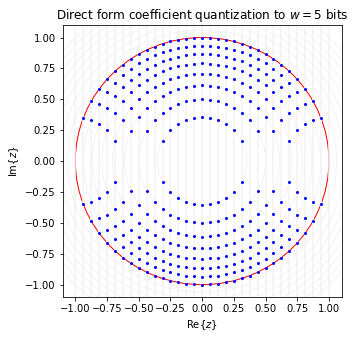

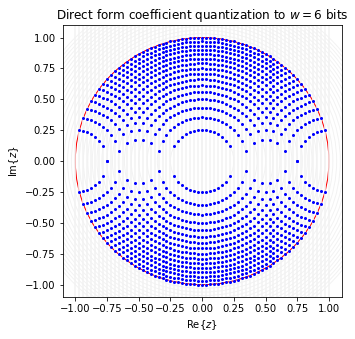

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.signal as sig
import itertools
import warnings
warnings.filterwarnings('ignore')

def compute_pole_locations(Q):
    a1 = np.arange(-2, 2+Q, Q)
    a2 = np.arange(0, 1+Q, Q)
    
    p = np.asarray([np.roots([1, n, m]) for (n,m) in itertools.product(a1, a2)])
    p = p[np.imag(p)!=0]

    return p


def plot_pole_locations(p, Q):
    ax = plt.gca()
    for n in np.arange(np.ceil(2/Q)+1):
        circle = Circle((0,0), radius=np.sqrt(n*Q), fill=False, color='black', ls='solid', alpha=0.05)
        ax.add_patch(circle)
        ax.axvline(.5*n*Q, color='0.95')
        ax.axvline(-.5*n*Q, color='0.95')

    unit_circle = Circle((0,0), radius=1, fill=False, color='red', ls='solid')
    ax.add_patch(unit_circle)    

    plt.plot(np.real(p), np.imag(p), 'b.', ms = 4)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis([-1.1, 1.1, -1.1, 1.1])

# compute and plot pole locations
for w in [5,6]:
    Q = 2/(2**(w-1))  # quantization stepsize
    plt.figure(figsize=(5, 5))
    p = compute_pole_locations(Q)
    plot_pole_locations(p, Q)
    plt.title(r'Direct form coefficient quantization to $w=%d$ bits'%w)

**Exercise**

* What consequences does the distribution of pole locations on the desired characteristics of a filter have for e.g. low/high frequencies?

Solution: Quantization of the original filter coefficients leads to a limited number of possible pole and zero locations. These locations are not uniformly distributed over the $z$-plane, as can be observed from above illustrations. The density of potential locations is especially low for low frequencies and close to the Nyquist frequency. The properties of a designed filter having poles and/or zeros at low/high frequencies will potentially deviate more when quantizing its coefficients, as a consequence.

### Solución

- La cuantificación de los coeficientes de filtro originales conduce a un número limitado de posibles ubicaciones de polos y cero. Estos lugares no están distribuidos uniformemente sobre el avión de $z$, como se puede observar en las ilustraciones anteriores. La densidad de las localizaciones potenciales es especialmente baja para las frecuencias bajas y cerca de la frecuencia de Nyquist. Las propiedades de un filtro diseñado con polos y/o ceros en frecuencias bajas/altas se desviarán potencialmente más cuando se cuantifiquen sus coeficientes, como consecuencia.

### Coupled Form

Besides the quantization step $Q$, the pole distribution depends also on the topology of the filter. In order to gain a different distribution of pole locations after quantization, one has to derive structures where the coefficients of the multipliers are given by other values than the direct form coefficients $a_1$ and $a_2$. 

One of these alternative structures is the coupled form (also known as Gold & Rader structure)

![Coupled form second order section](coupled_form.png)

where $\Re\{z_\infty\} = r \cdot \cos \varphi$ and $\Im\{z_\infty\} = r \cdot \sin \varphi$ denote the real- and imaginary part of the complex pole $z_\infty$, respectively. Analysis of the structure reveals its difference equation as

\begin{align}
w[k] &= x[k] + \Re\{z_\infty\} \, w[k-1] - \Im\{z_\infty\} \, y[k-1] \\
y[k] &= \Im\{z_\infty\} \, w[k-1] + \Re\{z_\infty\} \, y[k-1]
\end{align}

and its transfer function as

\begin{equation}
H(z) = \frac{\Im\{z_\infty\} \; z^{-1}}{ 1 - 2 \Re\{z_\infty\} \; z^{-1} + (\Re\{z_\infty\}^2 + \Im\{z_\infty\}^2) \; z^{-2} }
\end{equation}

Note that the numerator of the transfer function differs from the recursive only SOS given above. However, this can be considered in the design of the transfer function of a general SOS.

The real- and imaginary part of the pole $z_\infty$ occur directly as coefficients for the multipliers in the coupled form. Quantization of these coefficients results therefore in a Cartesian grid of possible pole locations in the $z$-plane. This is illustrated in the following.

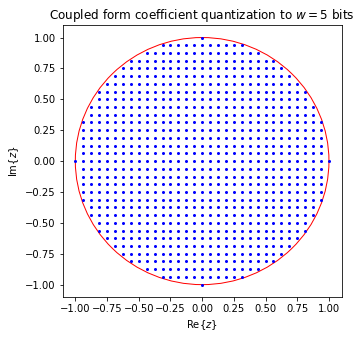

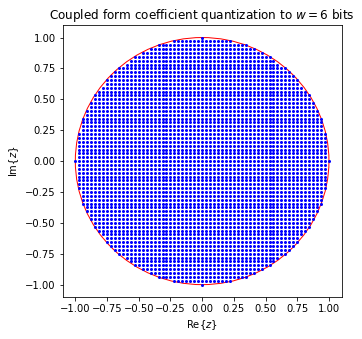

In [2]:
def compute_pole_locations(w):
    Q = 1/(2**(w-1))  # quantization stepsize
    a1 = np.arange(-1, 1+Q, Q)
    a2 = np.arange(-1, 1+Q, Q)
    
    p = np.asarray([n+1j*m for (n,m) in itertools.product(a1, a2) if n**2+m**2 <= 1])

    return p

def plot_pole_locations(p):
    ax = plt.gca()
    
    unit_circle = Circle((0,0), radius=1, fill=False, color='red', ls='solid')
    ax.add_patch(unit_circle)    

    plt.plot(np.real(p), np.imag(p), 'b.', ms = 4)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis([-1.1, 1.1, -1.1, 1.1])

    
# compute and plot pole locations
for w in [5,6]:
    plt.figure(figsize=(5, 5))
    p = compute_pole_locations(w)
    plot_pole_locations(p)
    plt.title(r'Coupled form coefficient quantization to $w=%d$ bits'%w)

**Excercise**

* What is the benefit of this representation in comparison to the direct from discussed in the previous section?

Solution: A befit of the coupled form is a uniform distribution of potential pole and zero locations in the $z$-plane. This holds especially for low frequencies and close to the Nyquist frequency.

### Solución

- Un befit de la forma acoplada es una distribución uniforme del poste potencial y cero localizaciones en el plano $z$. Esto es especialmente válido para las frecuencias bajas y 

### Example - Influence of coefficient quantization

The following example illustrates the effects of coefficient quantization for a recursive [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) realized in cascaded SOSs in transposed direct form II.

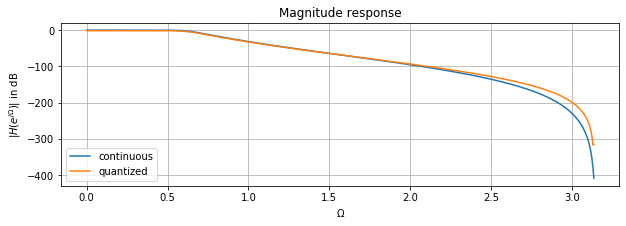

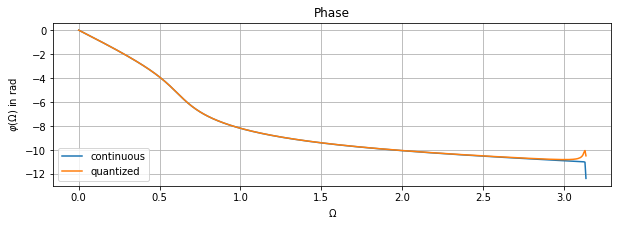

In [3]:
w = 16  # wordlength of filter coefficients
N = 7  # order of filter


def uniform_midtread_quantizer(x, w, xmin=1):
    # quantization step
    Q = xmin/(2**(w-1))
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -xmin)
    x[idx] = -1
    idx = np.where(x > xmin - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ


def zplane(z, p, title='Poles and Zeros'):
    "Plots zero and pole locations in the complex z-plane"
    ax = plt.gca()
    
    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms = 10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms = 10)
    unit_circle = Circle((0,0), radius=1, fill=False,
                         color='black', ls='solid', alpha=0.9)
    ax.add_patch(unit_circle)
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    
    plt.title(title)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis('equal')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid()

    
# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=1)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

**Exercise**

* Decrease the word length `w` of the filter. What happens? At what word length does the filter become unstable?
* Increase the order `N` of the filter for a fixed word length `w`. What happens?

Solution: The deviations from the continuous (desired) realization of the filter increase with decreasing word length. The filter with order `N=5` becomes unstable for `w < 10`. Increasing the order `N` of the filter for a fixed word length results also in instabilities. Consequently, for a high order filter also a higher word length is required.

### Solución

- Las desviaciones de la realización continua (deseada) del filtro aumentan con la longitud de `w`. El filtro con orden `N=5` se vuelve inestable para `w < 10`. El aumento del orden `N` del filtro para una longitud `w` fija resulta también en inestabilidades. Por consiguiente, para un filtro de alto orden también se requiere una longitud de palabra más alta.

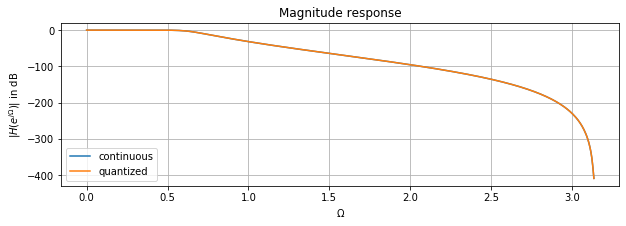

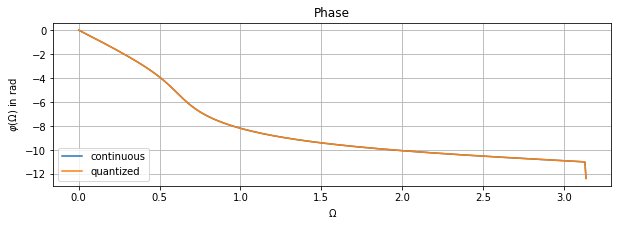

In [4]:
w = 50  # wordlength of filter coefficients
N = 7  # order of filter

# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=1)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

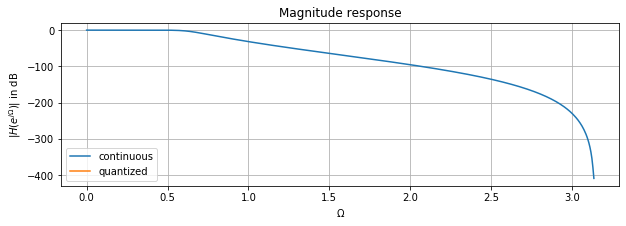

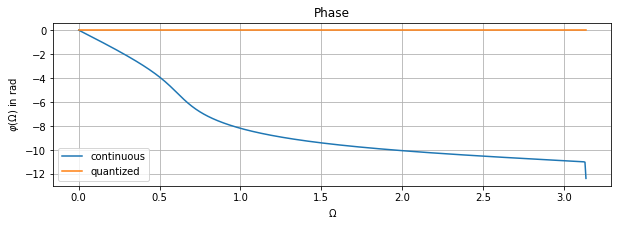

In [5]:
w = 5 # wordlength of filter coefficients
N = 7  # order of filter

# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=1)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

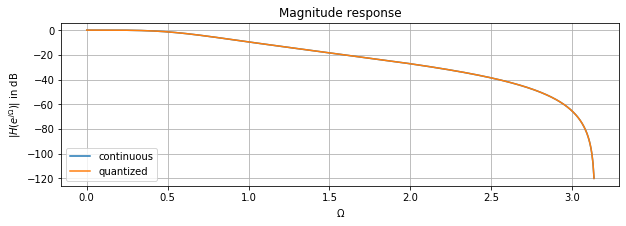

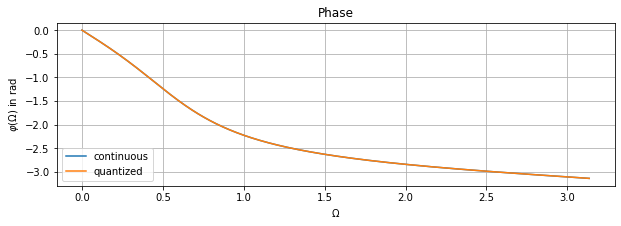

In [6]:
w = 16  # wordlength of filter coefficients
N = 2  # order of filter

# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=1)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

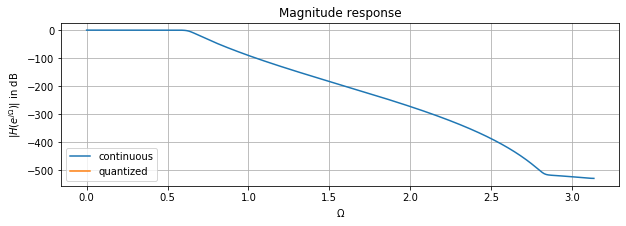

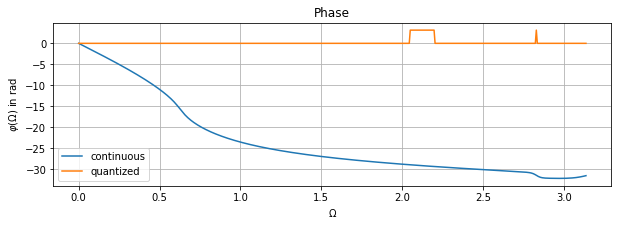

In [7]:
w = 16  # wordlength of filter coefficients
N = 20  # order of filter

# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=1)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples, 2016-2018*.